- https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/apo25m/K21_071+10/7561/57294/
- https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/exposures/apogee-n/57294/

in the ap1D: row = 300-fiberid


NOTE: data model is slightly wrong! have OBJECT

- [apCframe data model](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/visit/TELESCOPE/FIELD/PLATE_ID/MJD5/apCframe.html)
- [apVisit data model](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/visit/TELESCOPE/FIELD/PLATE_ID/MJD5/apVisit.html)

In [15]:
import os
from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

In [5]:
apid = '2M19241171+3650235'

In [6]:
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits')
allvisit = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-l33alpha.fits')

In [7]:
metadata = at.Table.read('/mnt/home/apricewhelan/projects/hq/cache/dr17-beta-202010/metadata-thejoker.fits')
metadata = at.join(metadata, allstar, keys='APOGEE_ID')

In [229]:
metadata[metadata['APOGEE_ID'] == apid]

APOGEE_ID,MAP_K,MAP_M0,MAP_P,MAP_e,MAP_ln_likelihood,MAP_ln_prior,MAP_omega,MAP_s,MAP_v0,baseline,constant_ln_evidence,joker_completed,kepler_ln_evidence,max_phase_gap,max_unmarginalized_ln_likelihood,n_visits,periods_spanned,phase_coverage,phase_coverage_per_period,t0_bmjd,unimodal,constant_ln_likelihood,robust_constant_ln_likelihood,robust_success,FILE,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NINST,NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIA_SOURCE_ID,GAIA_PARALLAX,GAIA_PARALLAX_ERROR,GAIA_PMRA,GAIA_PMRA_ERROR,GAIA_PMDEC,GAIA_PMDEC_ERROR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,GAIA_A_G_VAL,GAIA_E_BP_MIN_RP_VAL,GAIA_RADIAL_VELOCITY,GAIA_RADIAL_VELOCITY_ERROR,GAIA_R_EST,GAIA_R_LO,GAIA_R_HI,ASPCAP_GRID,"FPARAM_GRID [20,9]",CHI2_CLASS [20],FPARAM [9],"FPARAM_COV [9,9]",ASPCAP_CHI2,PARAM [9],"PARAM_COV [9,9]",PARAMFLAG [9],ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],ELEM_CHI2 [26],ELEMFLAG [26],SNREV,EXTRATARG,MEMBERFLAG,MEMBER,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_ERR,CU_FE_FLAG,GE_FE,GE_FE_ERR,GE_FE_FLAG,RB_FE,RB_FE_ERR,RB_FE_FLAG,CE_FE,CE_FE_ERR,CE_FE_FLAG,ND_FE,ND_FE_ERR,ND_FE_FLAG,YB_FE,YB_FE_ERR,YB_FE_FLAG,APSTAR_ID,ASPCAP_ID,TARGET_ID
,km / s,rad,d,,,,rad,km / s,km / s,d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,int64,float64,float64,int64,float64,bool,float64,float64,bool,bytes64,bytes6,int64,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,float32,float32,bytes16,float32,bytes32,float32,float32,int64,int64,int64,int64,int64,int64,bytes132,bytes32,bytes32,int64,int64,int64,int64,float32,uint64,bytes132,uint64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,uint64,uint64,bytes132,float32,float64,float32,float32,float64,float32,float32,float32,float32,float32,uint64,float32,uint32,uint32,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint32,float32,float32,u

In [8]:
visits = allvisit[allvisit['APOGEE_ID'] == apid]
star = allstar[allstar['APOGEE_ID'] == apid]

In [11]:
# vari_mask = (
#     (metadata['APOGEE_ID'] != star['APOGEE_ID']) &
#     metadata['unimodal'] & 
#     (metadata['MAP_P'] < 5*u.day) & 
#     (metadata['N_COMPONENTS'] == 1) &
#     (np.abs(metadata['LOGG'] - star['LOGG']) < 0.2) &
#     (np.abs(metadata['TEFF'] - star['TEFF']) < 200) &
#     (np.abs(metadata['M_H'] - star['M_H']) < 0.2) &
#     (metadata['SNR'] > 100))

vari_mask = (
    (metadata['APOGEE_ID'] != star['APOGEE_ID']) &
    metadata['unimodal'] & 
    (metadata['MAP_P'] < 3*u.day) & 
    (metadata['N_COMPONENTS'] == 1) &
    (np.abs(metadata['LOGG'] - star['LOGG']) < 0.5) &
    (np.abs(metadata['TEFF'] - star['TEFF']) < 200) &
    (np.abs(metadata['M_H'] - star['M_H']) < 0.3) &
    (metadata['SNR'] > 100))
vari_idx = np.where(vari_mask)[0][0]

vari_star = allstar[allstar['APOGEE_ID'] == metadata[vari_idx]['APOGEE_ID']][0]
vari_visits = allvisit[allvisit['APOGEE_ID'] == vari_star['APOGEE_ID']]
vari_P = metadata[vari_idx]['MAP_P']
vari_mask.sum()

2

In [14]:
orbit = extract_MAP_sample(at.QTable(metadata[vari_idx])).get_orbit()

In [16]:
ts = Time(vari_visits['JD'], format='jd')
(orbit.radial_velocity(ts) - orbit.radial_velocity(ts + 0.1)) / 0.1

<Quantity [ -50.61822022,  254.59540725, -252.98619854, -249.8515385 ,
           -231.90026806] km / s>

Text(0, 0.5, 'RV [km/s]')

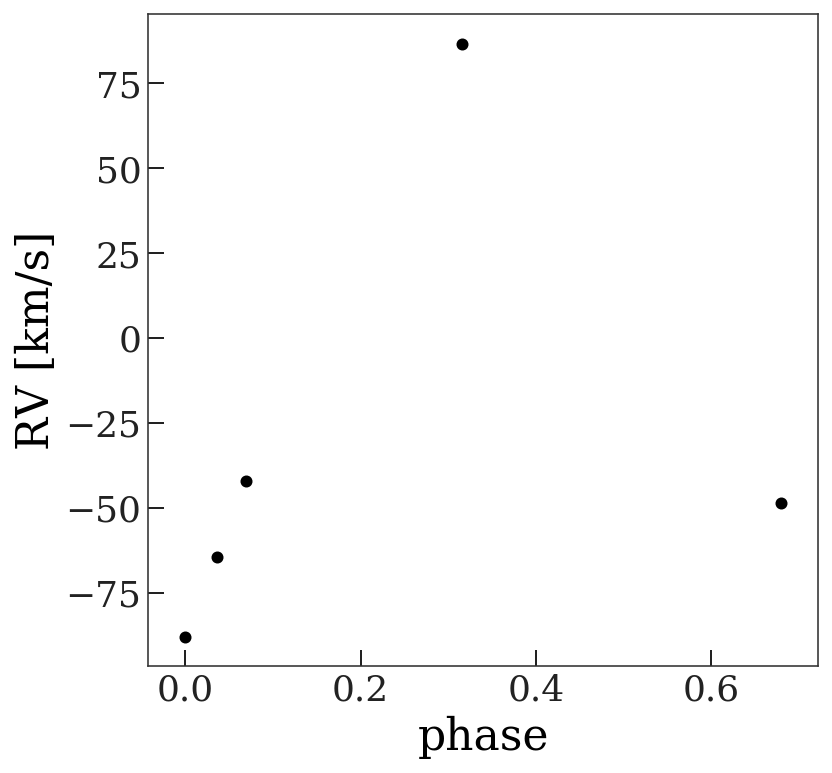

In [171]:
vari_phase = (vari_visits['JD'] - vari_visits['JD'].min()) % vari_P
plt.scatter(
    ((vari_visits['JD'] - vari_visits['JD'].min()) / vari_P) % 1,
    vari_visits['VHELIO'])

# vari_visit = vari_visits[vari_phase.argsort()][1]
vari_visit = vari_visits[3]
plt.xlabel('phase')
plt.ylabel('RV [km/s]')

In [194]:
# RV null
# null_mask = (
#     (allstar['APOGEE_ID'] != star['APOGEE_ID']) &
#     (allstar['VSCATTER'] < 0.2) &
#     (allstar['NVISITS'] > 8) &
#     (allstar['TELESCOPE'] == 'apo25m') &
#     (np.abs(allstar['LOGG'] - star['LOGG']) < 0.2) &
#     (np.abs(allstar['TEFF'] - star['TEFF']) < 50) &
#     (np.abs(allstar['M_H'] - star['M_H']) < 0.1) &
#     (allstar['SNR'] > 100))
# null_idx = np.where(null_mask)[0][2]

# null_star = allstar[allstar['APOGEE_ID'] == allstar[null_idx]['APOGEE_ID']][0]
# null_visits = allvisit[allvisit['APOGEE_ID'] == null_star['APOGEE_ID']]
# null_visit = null_visits[null_visits['SNR'].argsort()[::-1]][0]
# null_mask.sum()

# On same plate, MJD
null_mask = (
    (allvisit['APOGEE_ID'] != star['APOGEE_ID']) &
    (allvisit['PLATE'] == vari_visit['PLATE']) &
    (allvisit['MJD'] == vari_visit['MJD']) &
    (np.abs(allvisit['RV_TEFF'] - vari_visit['RV_TEFF']) < 300) &
    (np.abs(allvisit['RV_LOGG'] - vari_visit['RV_LOGG']) < 0.3) &
    (np.abs(allvisit['RV_FEH'] - vari_visit['RV_FEH']) < 0.4))
print(null_mask.sum())
null_idx = np.where(null_mask)[0][1]
null_visit = allvisit[null_idx]
null_visits = allvisit[allvisit['APOGEE_ID'] == null_visit['APOGEE_ID']]

2


<ErrorbarContainer object of 3 artists>

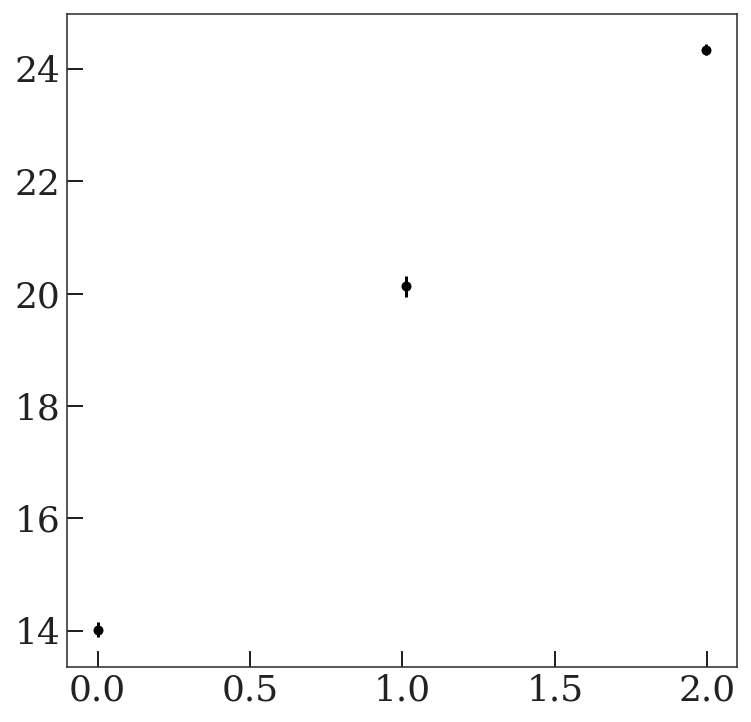

In [196]:
plt.errorbar(
    (null_visits['JD'] - null_visits['JD'].min()),
    null_visits['VHELIO'],
    null_visits['VRELERR'],
    ls='none', marker='o')

In [197]:
star['SNR'], null_star['SNR'], vari_star['SNR']

(<Column name='SNR' dtype='float32' length=1>
 592.35095, 120.33755, 251.36528)

# START

In [198]:
# visit = visits[5]
visit = null_visit
# visit = vari_visit
visit

APOGEE_ID,TARGET_ID,FILE,FIBERID,PLATE,MJD,TELESCOPE,SURVEY,FIELD,PROGRAMNAME,ALT_ID,LOCATION_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,APOGEE_TARGET4,TARGFLAGS,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,VLSR,VGSR,CHISQ,SYNTHFILE,MIN_H,MAX_H,MIN_JK,MAX_JK,VREL,VRELERR,VHELIO,BC,RV_TEFF,RV_LOGG,RV_FEH,RV_CARB,RV_ALPHA,XCORR_VREL,XCORR_VRELERR,XCORR_VHELIO,CCFWHM,AUTOFWHM,N_COMPONENTS,RV_COMPONENTS [3],RV_FLAG
bytes19,bytes23,bytes45,int16,bytes16,int32,bytes6,bytes14,bytes19,bytes18,bytes47,int16,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes15,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,bytes20,float32,bytes17,float32,float32,int32,int32,int32,int32,bytes192,float32,uint64,bytes74,bytes23,float64,float32,float32,float32,bytes18,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float32,int64
2M11343280+4914282,2M11343280+4914282,apVisit-dr17-8990-57859-205.fits,205,8990,57859,apo25m,manga-apogee2,152+63_MGA,manga,none,2342,173.636685,49.241192,151.60695479255682,63.3864339523813,11.794,0.018,11.315,0.015,11.222,0.023,2MASS,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,-9999.99,11.207,0.021,-9999.99,-9999.99,-1,1,-32.9,-2.3,URAT1,0.0044607325,SFD,0.053243816,0.014770638,-2147383264,0,0,0,"APOGEE2_SFD_DERED,APOGEE2_SHORT,APOGEE2_MANGA_LED,APOGEE2_ONEBIN_GT_0_3",74.2983,2097152,MULTIPLE_SUSPECT,2017-04-16T02:09:34.910,2457859.64321,999999.0,999999.0,0.0,,7.0,11.5,0.3,9999.99,42.22590835996913,0.10000211734677533,24.34075554319667,-17.88515281677246,5100.579687509548,4.999999999999999,-0.7208053080711477,nan,nan,42.22590835996913,2.53383996281791,24.34075554319667,138.31937119946505,29.023123965203503,2,24.385918 .. 0.0,0


### Get apVisit file:

In [199]:
root_url = "https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr16/visit/"
sub_path = f"{visit['TELESCOPE']}/{visit['FIELD'].strip()}/{int(visit['PLATE']):04d}/{int(visit['MJD']):05d}/"

In [200]:
filename = f"apVisit-r12-{int(visit['PLATE']):04d}-{int(visit['MJD']):05d}-{int(visit['FIBERID']):03d}.fits"

url = os.path.join(root_url, sub_path, filename)
local_path = Path('../data') / filename
if not local_path.exists():
    print(f"downloading {filename}...")
    r = requests.get(url, auth=('sdss', '2.5-meters!'))
    with open(local_path, 'wb') as f:
        f.write(r.content)
        
apvisit = fits.open(local_path)

mask = (apvisit[3].data[0] % 15) > 0
flux_err = apvisit[2].data[0] * u.one
unc = StdDevUncertainty(flux_err)
apvisit_spectrum = Spectrum1D(
    flux=apvisit[1].data[0][~mask]*u.one,
    spectral_axis=apvisit[4].data[0][~mask]*u.angstrom,
    uncertainty=unc[~mask])

downloading apVisit-r12-8990-57859-205.fits...


### Get apCframe files:

In [201]:
hduls = {}

frames = [int(apvisit[0].header[k]) for k in apvisit[0].header.keys() 
          if k.startswith('FRAME')]

for frame in frames:
    filename = f'apCframe-a-{frame:08d}.fits'
    url = os.path.join(root_url, sub_path, filename)
    local_path = Path('../data') / filename
    if not local_path.exists():
        print(f"downloading {filename}...")
        r = requests.get(url, auth=('sdss', '2.5-meters!'))
        with open(local_path, 'wb') as f:
            f.write(r.content)

    hduls[frame] = fits.open(local_path)

In [202]:
# hdul = list(hduls.values())[0]
# hdul[0].header

In [203]:
def get_spectrum(hdulist, apogee_id, mask_flux=True):
    object_idx, = np.where(hdul[11].data['OBJECT'] == apogee_id)[0]

    flux = hdul[1].data[object_idx]
    flux_err = hdul[2].data[object_idx]
    wvln = hdul[4].data[object_idx]
    mask = (hdul[3].data[object_idx] % 15) > 0
    
    if mask_flux:
        unc = StdDevUncertainty(flux_err[~mask])
        spectrum = Spectrum1D(flux=flux[~mask]*u.one,
                              spectral_axis=wvln[~mask]*u.angstrom, 
                              uncertainty=unc)
    else:
        unc = StdDevUncertainty(flux_err)
        spectrum = Spectrum1D(flux=flux*u.one,
                              spectral_axis=wvln*u.angstrom, 
                              uncertainty=unc,
                              mask=mask)
    
    return spectrum

In [204]:
spectra = {}
for k, hdul in hduls.items():
    spectra[k] = get_spectrum(hdul, visit['APOGEE_ID'])

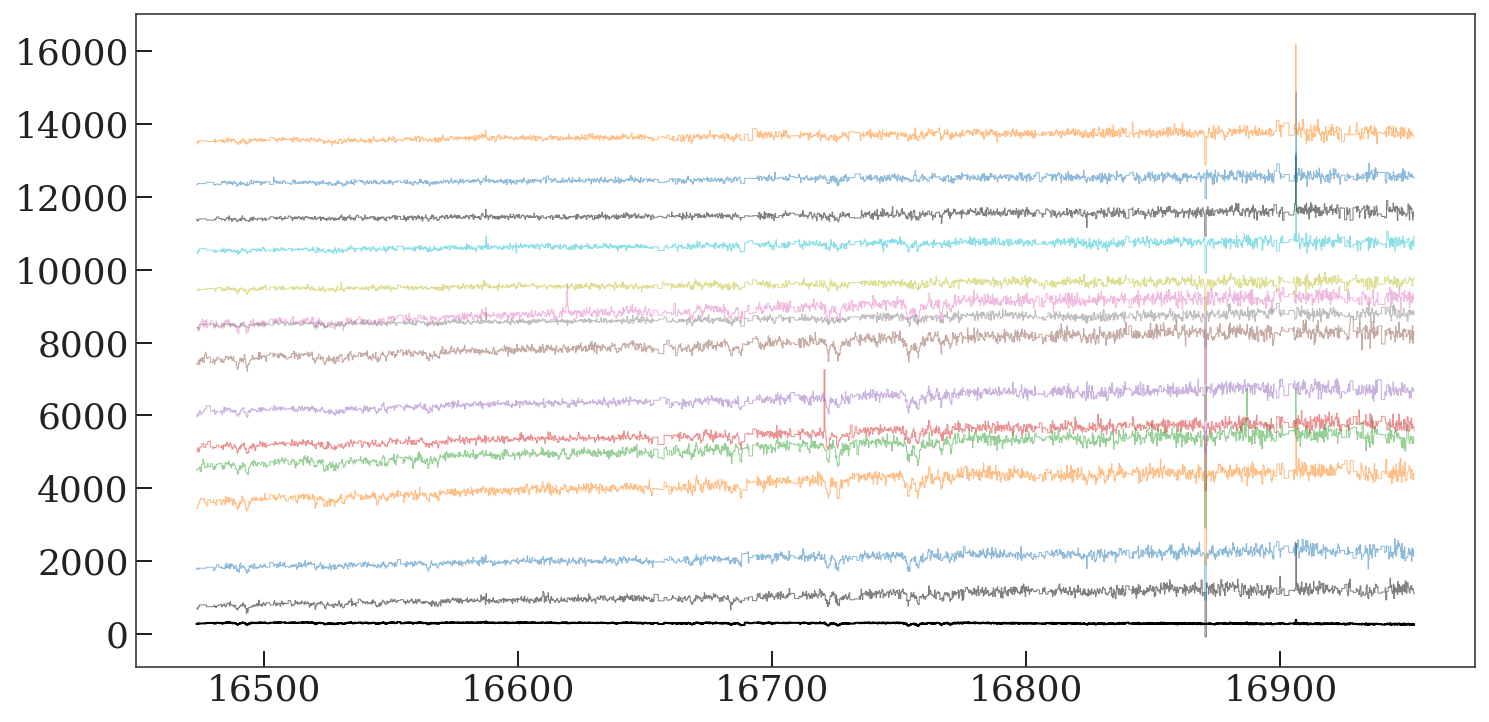

In [205]:
fig = plt.figure(figsize=(12, 6))

plt.plot(apvisit_spectrum.wavelength,
         apvisit_spectrum.flux,
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=1, color='k')

for i, s in enumerate(spectra.values()):
    plt.plot(s.wavelength, 
             s.flux + i*1000, 
             marker='', ls='-', lw=0.5,
             drawstyle='steps-mid', alpha=0.5)

# plt.xlim(16480, 16600)
# plt.ylim(0, 15000)

fig.set_facecolor('w')

In [206]:
# fig = plt.figure(figsize=(12, 6))

# cmap = plt.get_cmap('magma')
# for i, k in enumerate(sorted(spectra.keys())):
#     s = spectra[k]
#     plt.plot(s.wavelength, s.flux, 
#              color=cmap(i/len(spectra)),
#              marker='', ls='-', lw=2,
#              drawstyle='steps-mid', alpha=0.5)

# plt.xlim(16480, 16500)
# plt.ylim(500, 1200)

# fig.set_facecolor('w')

(0.5, 1.5)

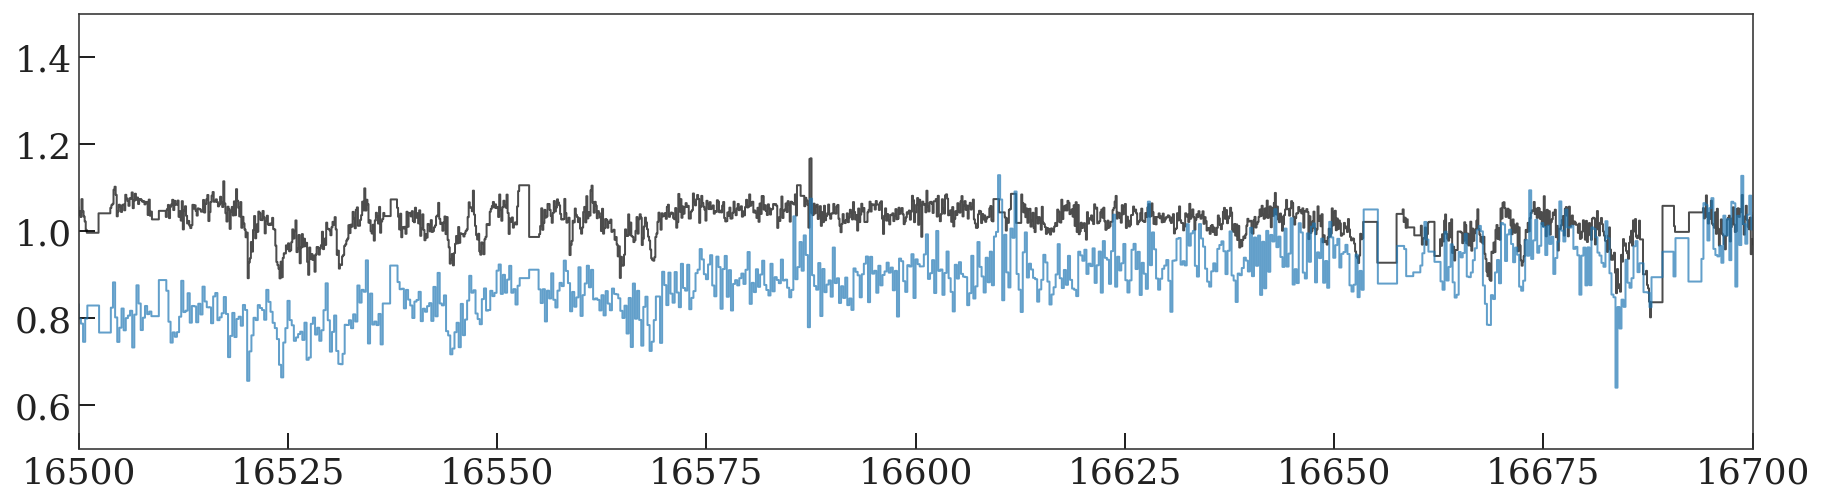

In [207]:
s = list(spectra.values())[0]

fig = plt.figure(figsize=(15, 4))
plt.plot(apvisit_spectrum.wavelength.value,
         apvisit_spectrum.flux / np.median(apvisit_spectrum.flux),
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=0.7)
plt.plot(s.wavelength.value,
         s.flux / np.median(s.flux),
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=0.7)
plt.xlim(16500, 16700)
plt.ylim(0.5, 1.5)

---

In [208]:
def doppler_factor(dv):
    return np.sqrt((speed_of_light + dv) / (speed_of_light - dv))

In [209]:
def shift_and_interpolate(ref_spectrum, dv, target_wavelength):
    """
    positive dv = shifting reference spectrum to red
    
    Parameters
    ----------
    
    """
    shifted_wvln = doppler_factor(dv) * ref_spectrum.wavelength.to_value(u.angstrom)
    idx = shifted_wvln.argsort()
    flux_interp = InterpolatedUnivariateSpline(
        shifted_wvln[idx], 
        ref_spectrum.flux.value[idx], 
        k=3, ext=3)
    return flux_interp(target_wavelength.to_value(u.angstrom))

In [210]:
from astropy.stats import sigma_clip

In [211]:
def normalize_ref_to_frame(frame_spectrum, ref_spectrum, deg=4, 
                           sigma_clip=True):
    ref_flux_on_frame_grid = shift_and_interpolate(
        ref_spectrum, 0.*u.km/u.s, frame_spectrum.wavelength)
    
    wvln = frame_spectrum.wavelength.to_value(u.angstrom)
    ref_wvln = np.median(wvln)
    
    # Design matrix
    d_wvln = wvln - ref_wvln
    terms = [ref_flux_on_frame_grid * d_wvln**i 
             for i in range(deg+1)]
    M = np.stack(terms).T
    
    if sigma_clip:
        clipped = sigma_clip(frame_spectrum.flux)
        n_mask = clipped.mask.sum()
        for n in range(1024):  # MAX ITER / infinity
            Cinv = np.ones(len(wvln))
            Cinv[clipped.mask] = 0.

            coeffs = np.linalg.solve(((M.T * Cinv) @ M), 
                                     (M.T * Cinv) @ frame_spectrum.flux)
            warped_flux = M @ coeffs

            clipped = sigma_clip(warped_flux - frame_spectrum.flux, sigma=5)
            if (clipped.mask.sum() - n_mask) < 4 and n > 2:
                break

            n_mask = clipped.mask.sum()
            
        clip_mask = clipped.mask
    
    else:
        coeffs = np.linalg.solve(M.T @ M, 
                                 M.T @ frame_spectrum.flux)
        clip_mask = None
        
    # Design matrix for (larger) apVisit spectrum
    d_wvln = ref_spectrum.wavelength.to_value(u.angstrom) - ref_wvln
    terms = [ref_spectrum.flux.value * d_wvln**i 
             for i in range(deg+1)]
    M = np.stack(terms).T
    normed_spectrum = Spectrum1D(M @ coeffs, spectral_axis=ref_spectrum.wavelength)
    
    return normed_spectrum, clip_mask

In [212]:
def estimate_kernel(frame_spectrum, normed_ref_spectrum, 
                    K_half=2, dv=4.5*u.km/u.s, clip_mask=None):
    
    if clip_mask is None:
        clip_mask = np.zeros(len(frame_spectrum.flux), dtype=bool)
    
    terms = []
    vs = np.arange(-K_half, K_half+1) * dv
    for v in vs:
        shifted_flux = shift_and_interpolate(normed_ref_spectrum, 
                                             v, 
                                             frame_spectrum.wavelength)
        terms.append(shifted_flux)
    M = np.stack(terms).T
    
    # Cinv = np.ones(len(frame_spectrum.flux))
    Cinv = 1 / frame_spectrum.uncertainty.array**2
    Cinv[clip_mask] = 0
    
    kernel = np.linalg.solve((M.T * Cinv) @ M,
                             (M.T * Cinv) @ frame_spectrum.flux)
    kernel_cov = np.linalg.inv((M.T * Cinv) @ M)
    
    denom = np.sqrt(np.diag((M.T * Cinv) @ M) * ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
    crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom
    
    return kernel, kernel_cov, vs, crosscorr

In [213]:
# mjds = []
# for frame, s in sorted(spectra.items(), key=lambda x: int(x[0])):
#     t = Time(hduls[frame][0].header['DATE-OBS'], scale='tai')
#     mjds.append(t.tcb.mjd)
# mjds = np.array(mjds)

In [214]:
from scipy.optimize import root

def parabola_hack(x, y):
    ps = np.polyfit(x, y, deg=2)
    poly_deriv = np.poly1d(np.polyder(ps))
    return root(poly_deriv, x0=x[1]).x[0], np.poly1d(ps)

In [227]:
s.spectral_axis

<SpectralCoord [16952.53504715, 16952.32256522, 16952.11006031, ...,
                16474.11950323, 16473.86181262, 16473.6041005 ] Angstrom, 
	radial_velocity=0.0 km / s, 
	redshift=0.0, 
	doppler_rest=0.0 Angstrom, 
	doppler_convention=None, 
	observer=None, 
	target=None>

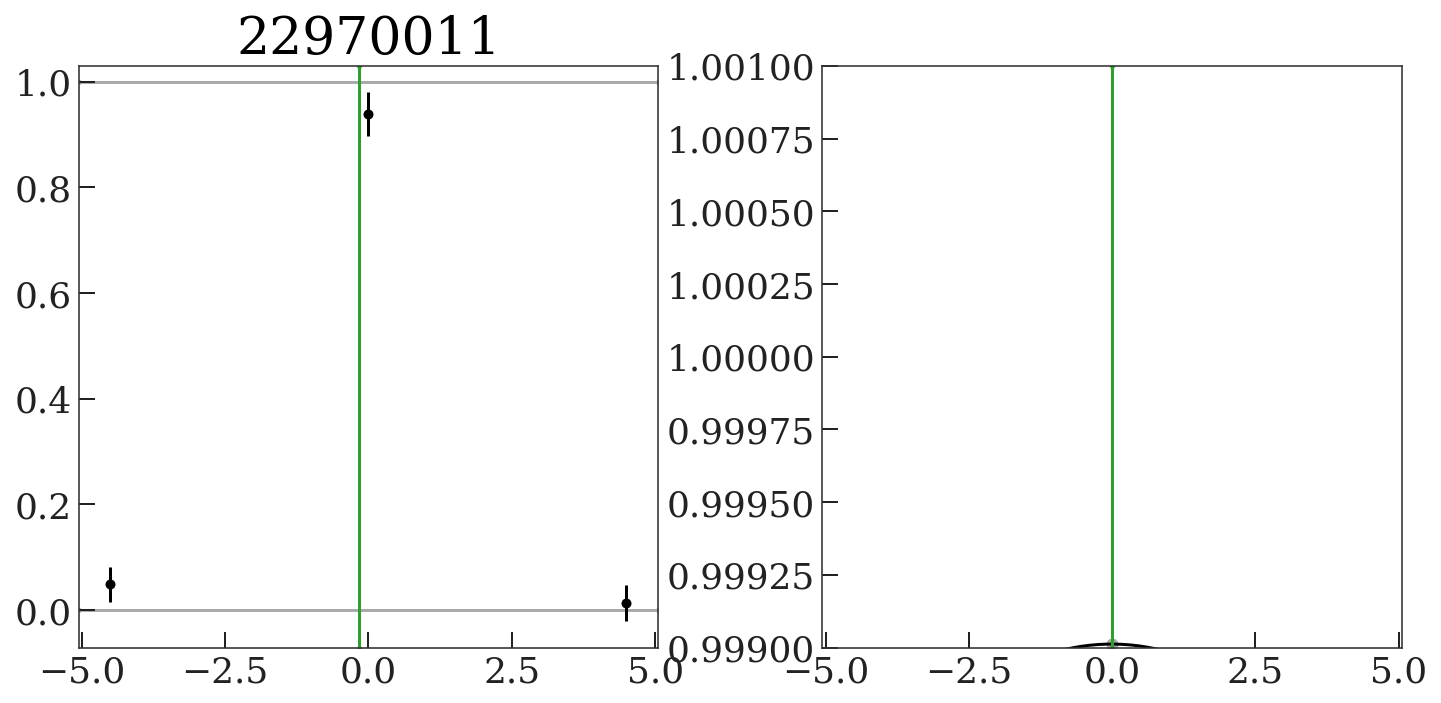

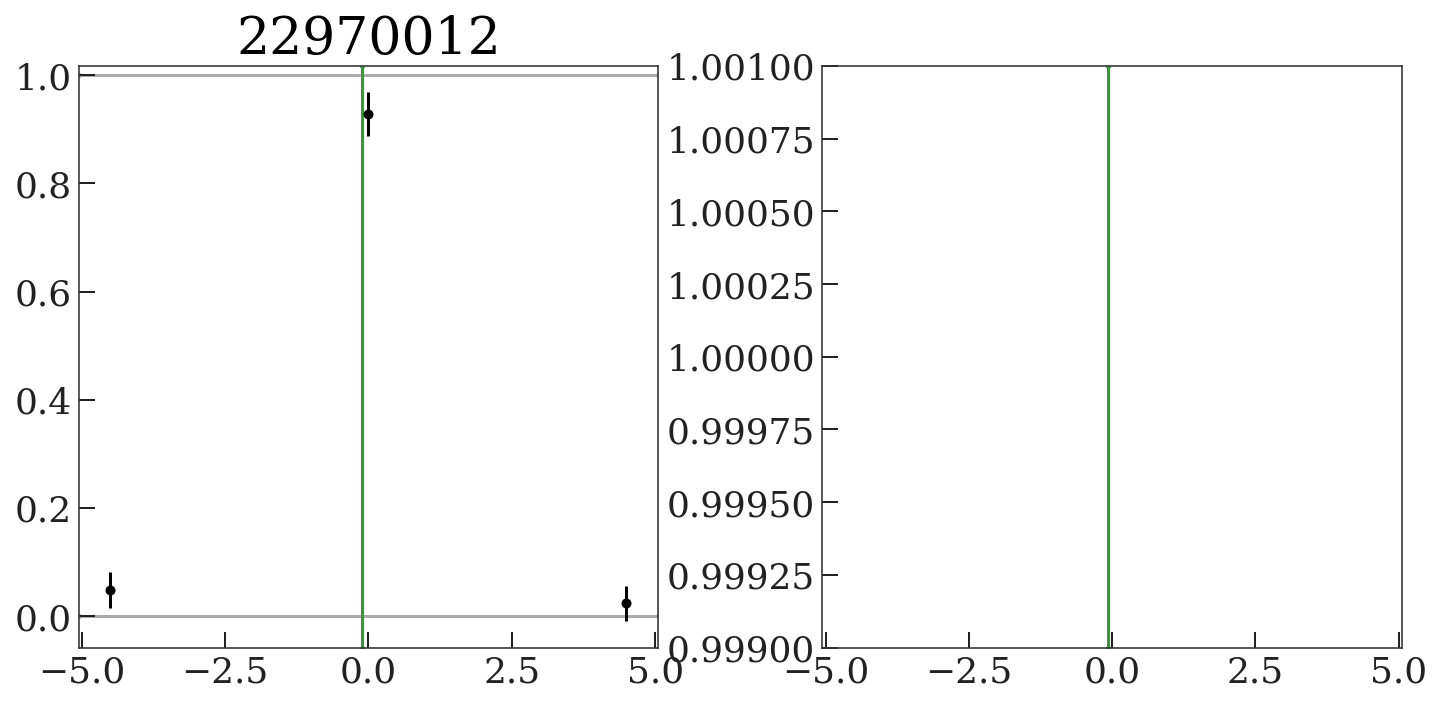

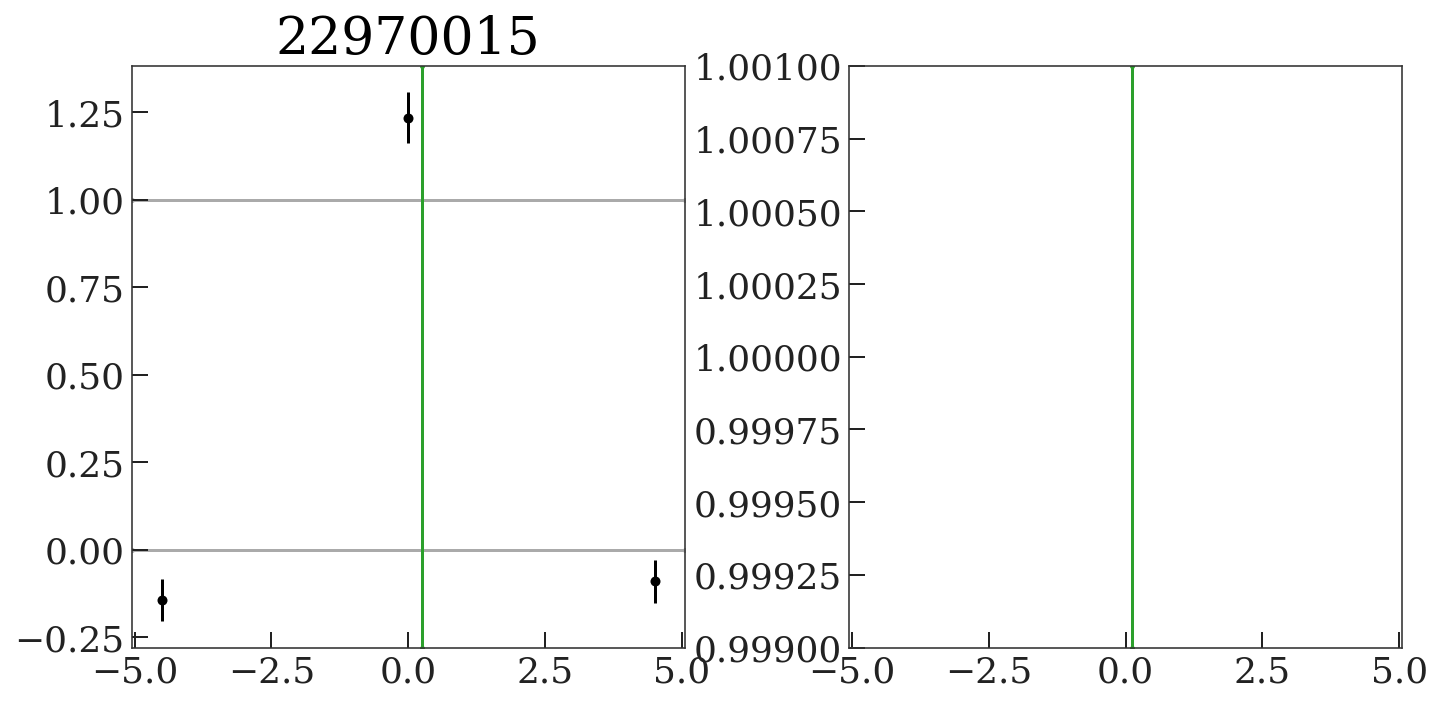

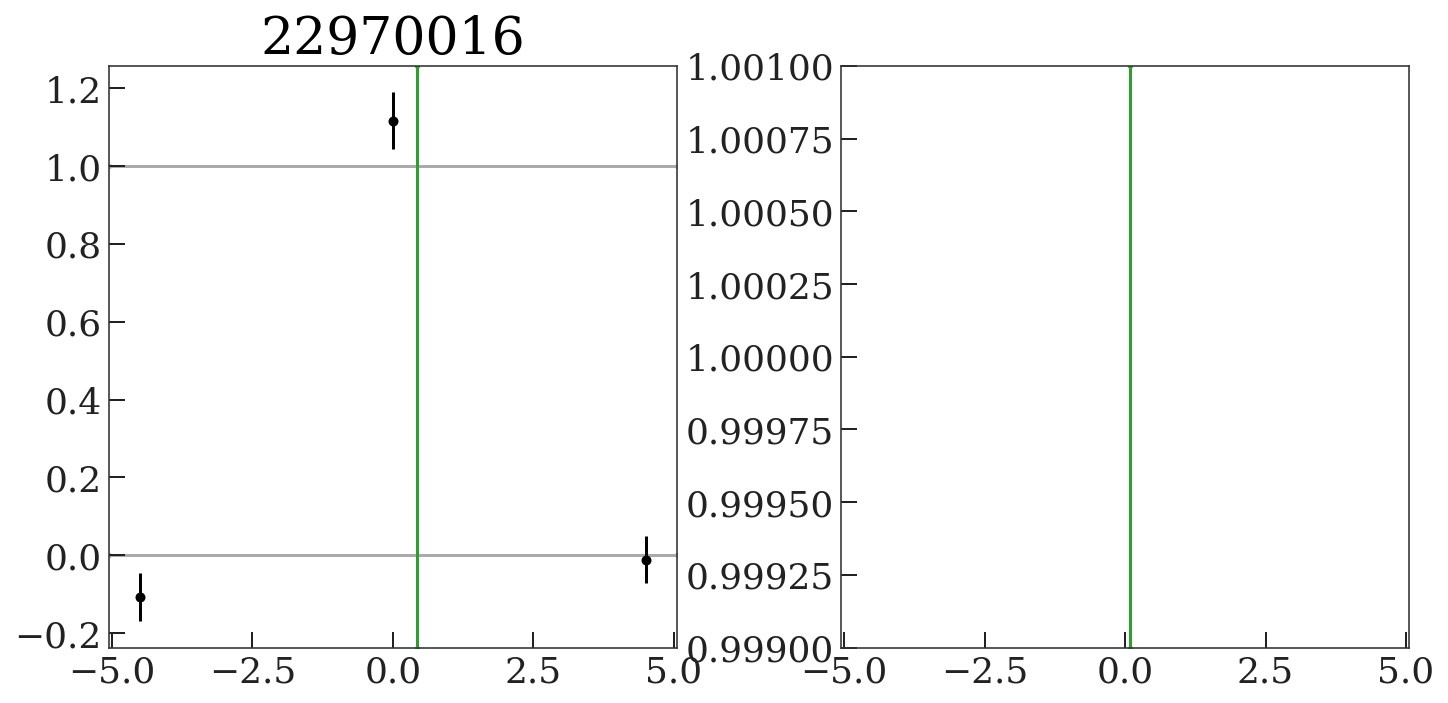

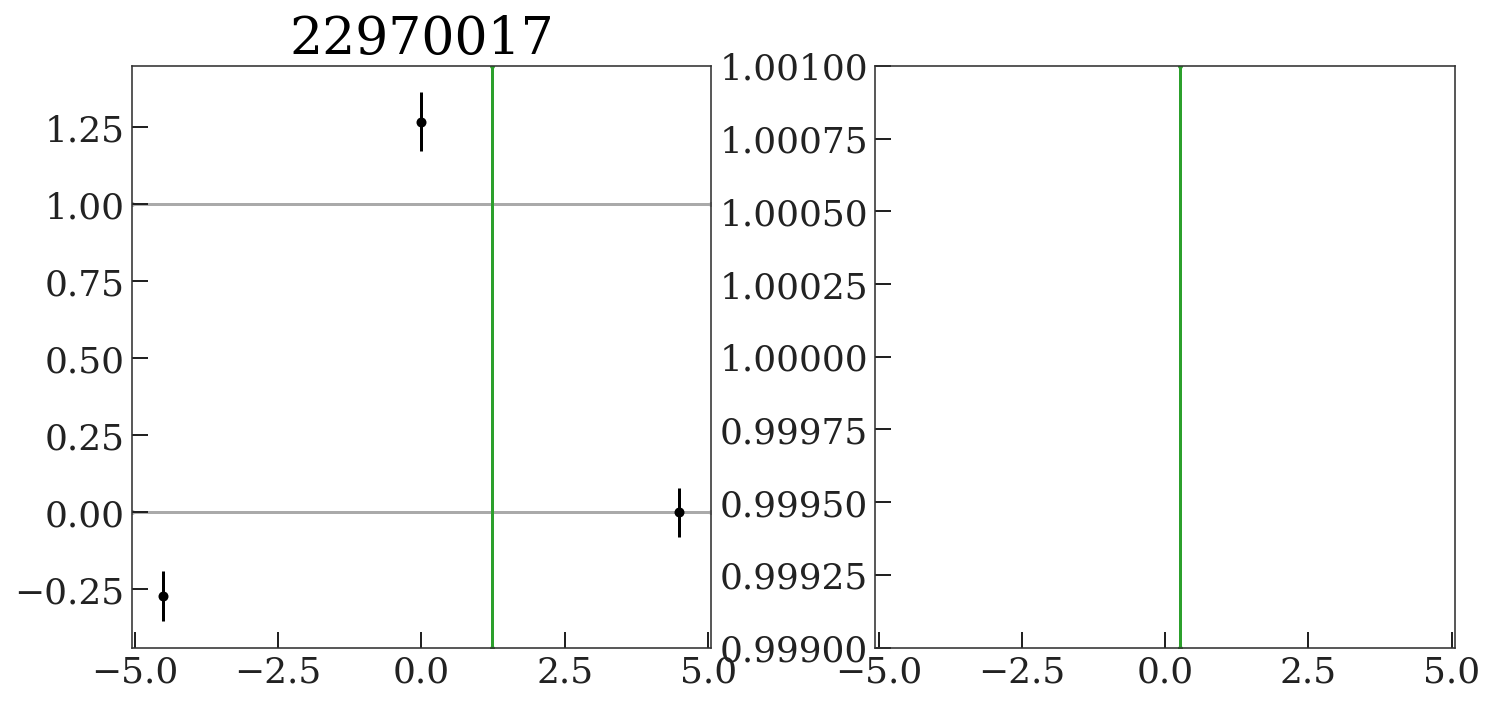

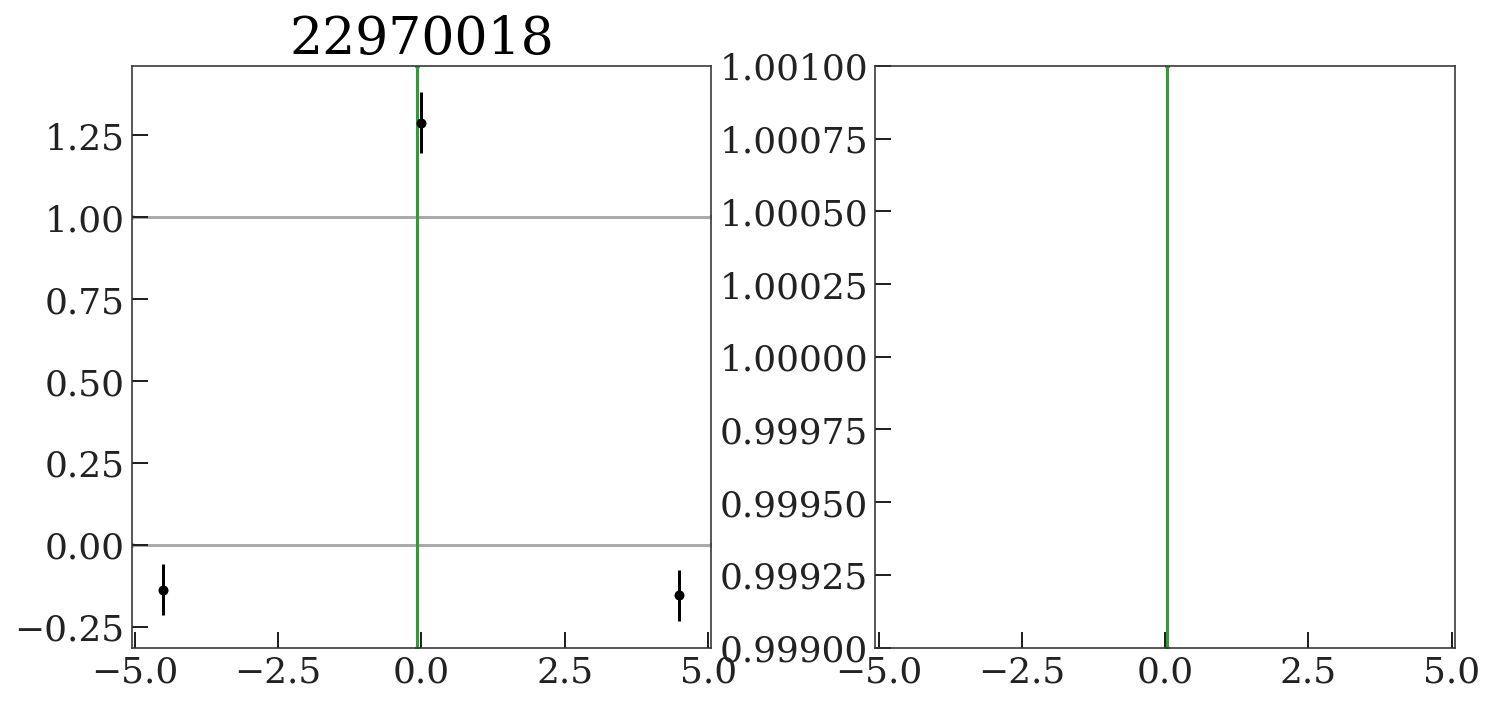

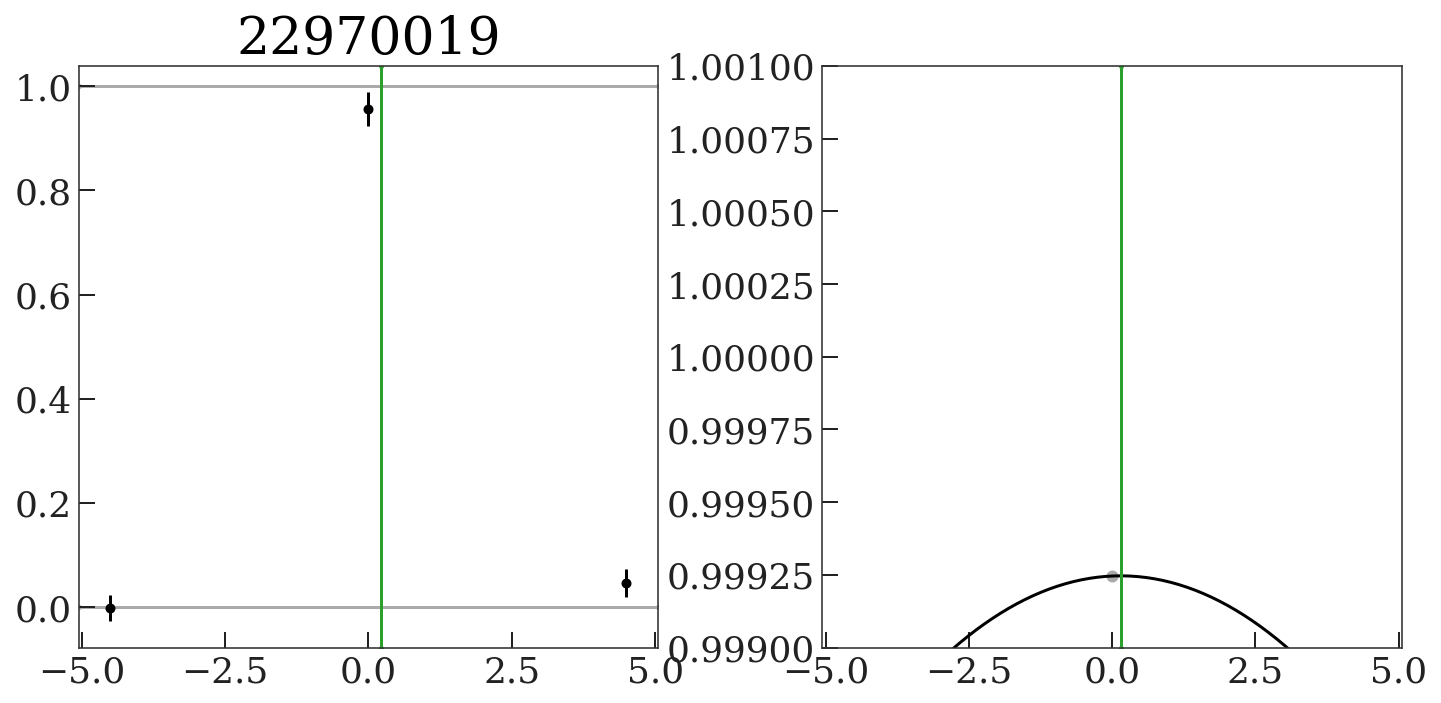

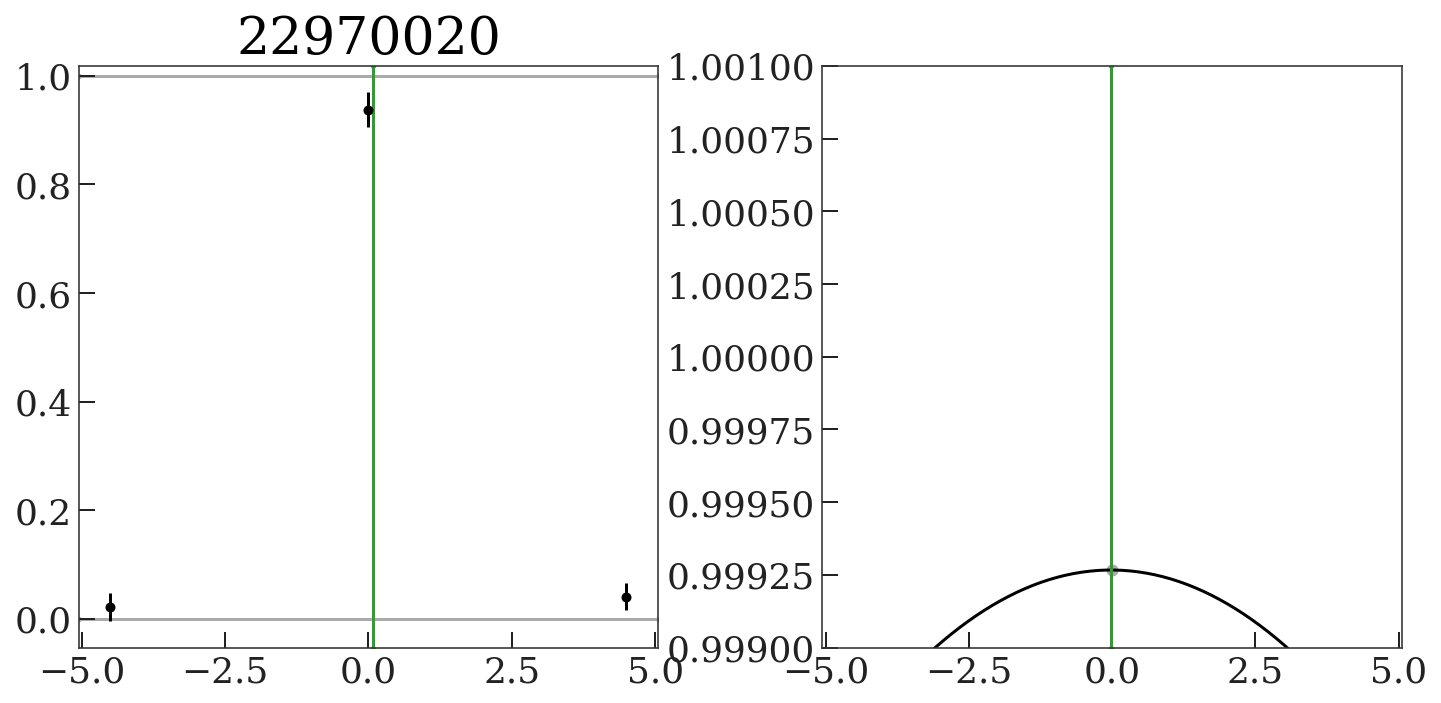

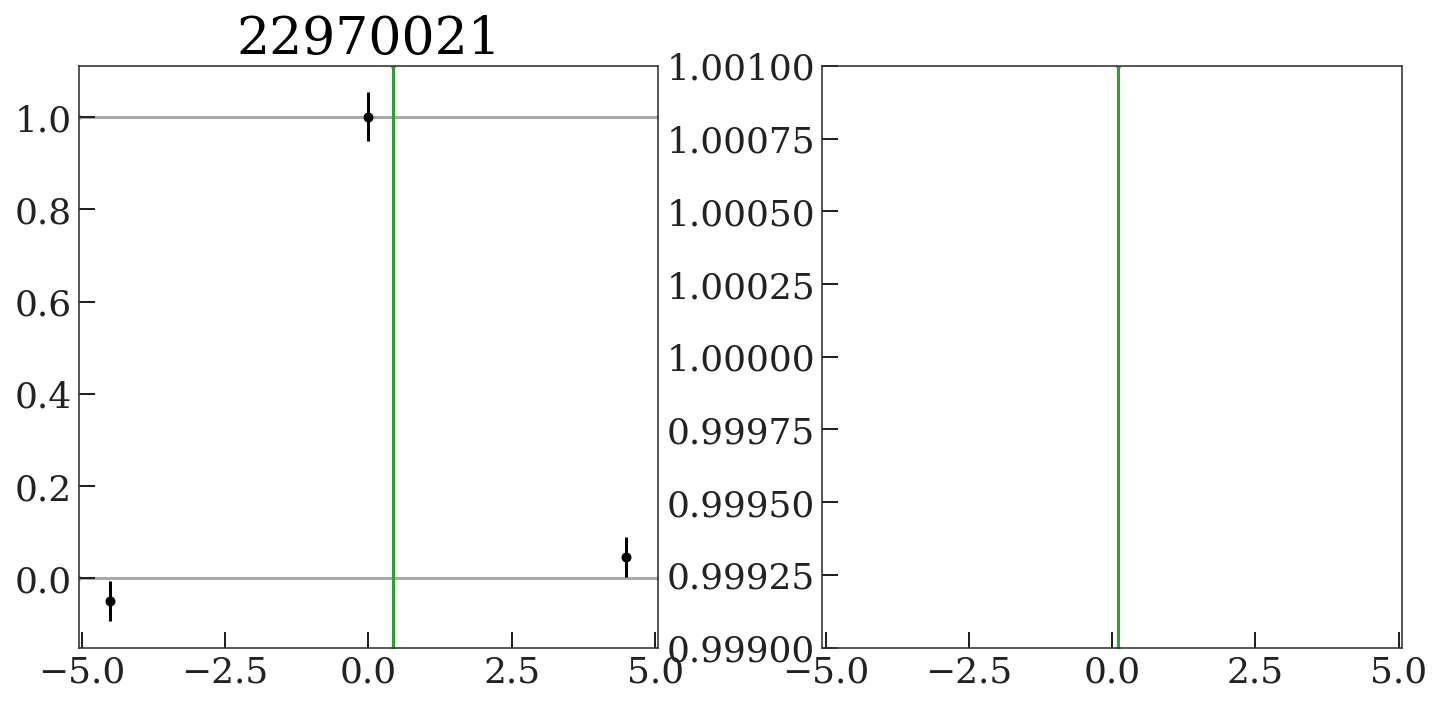

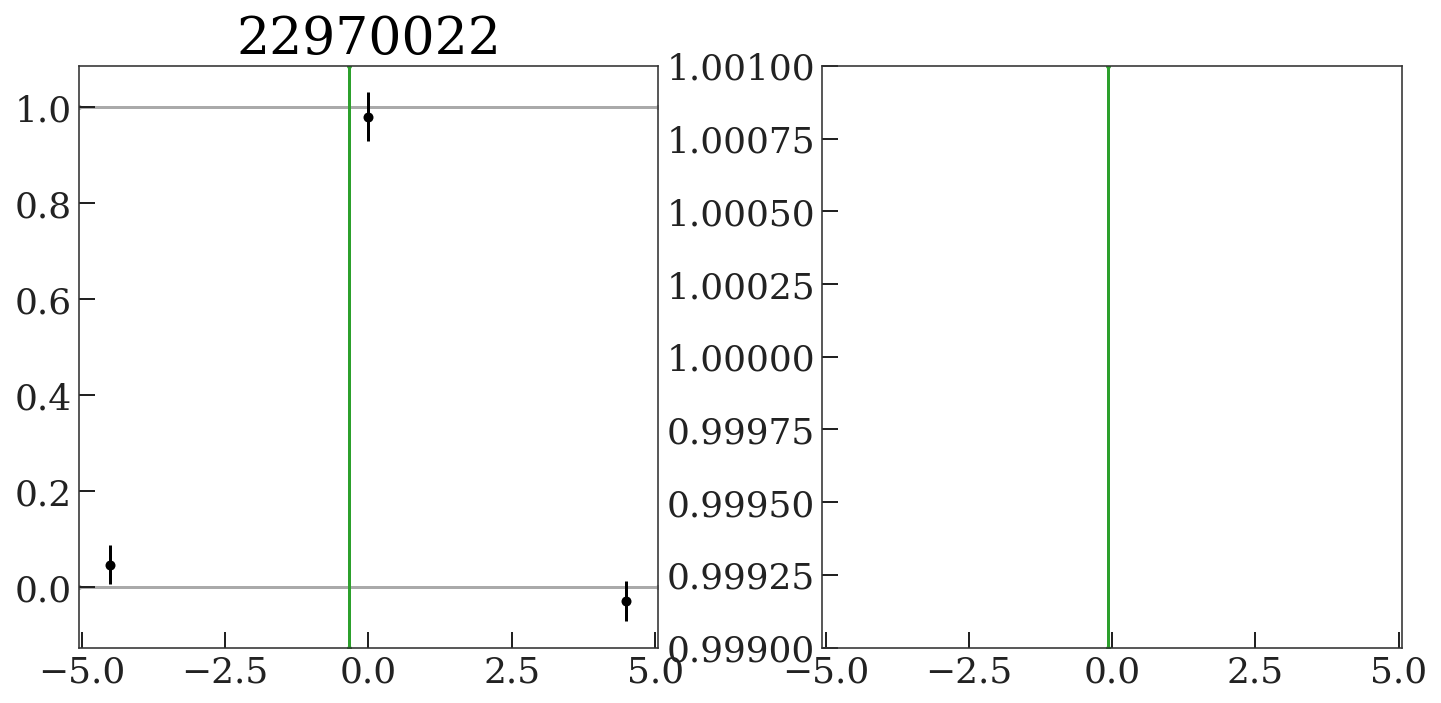

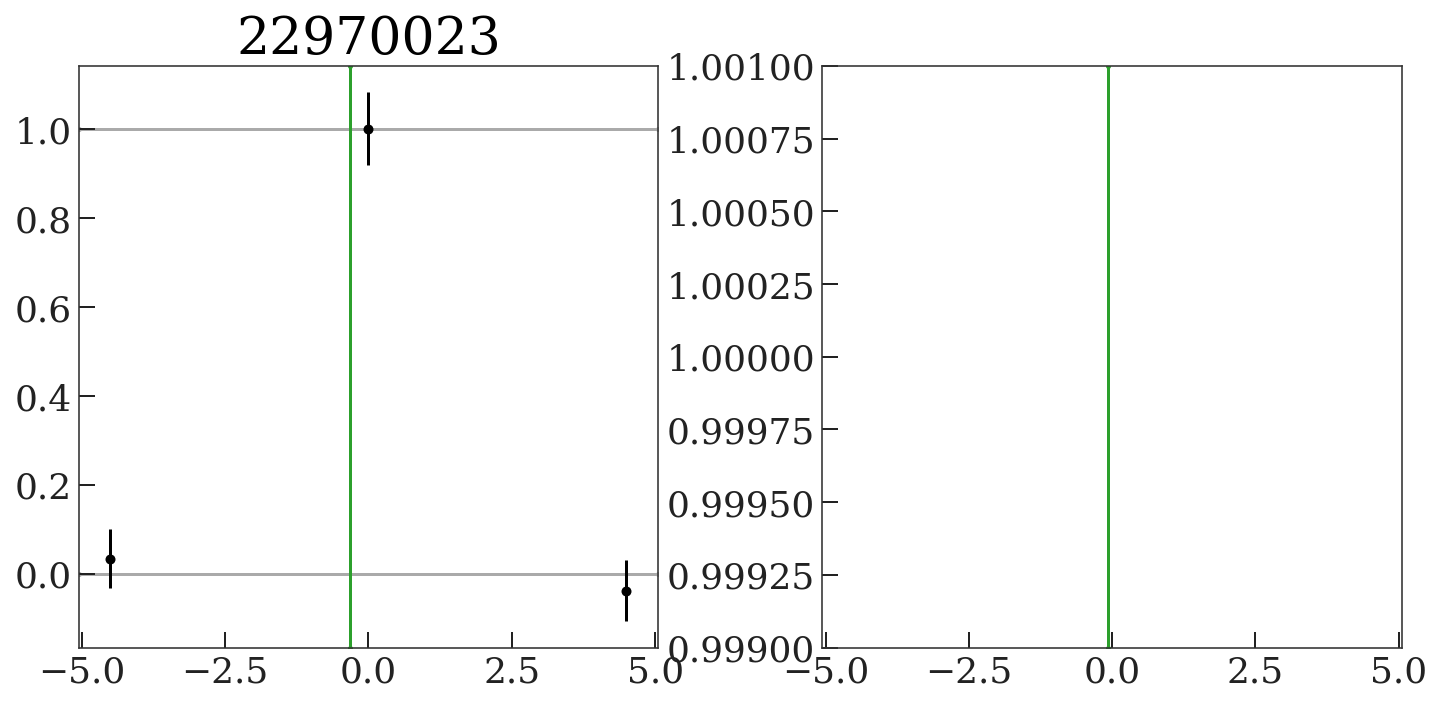

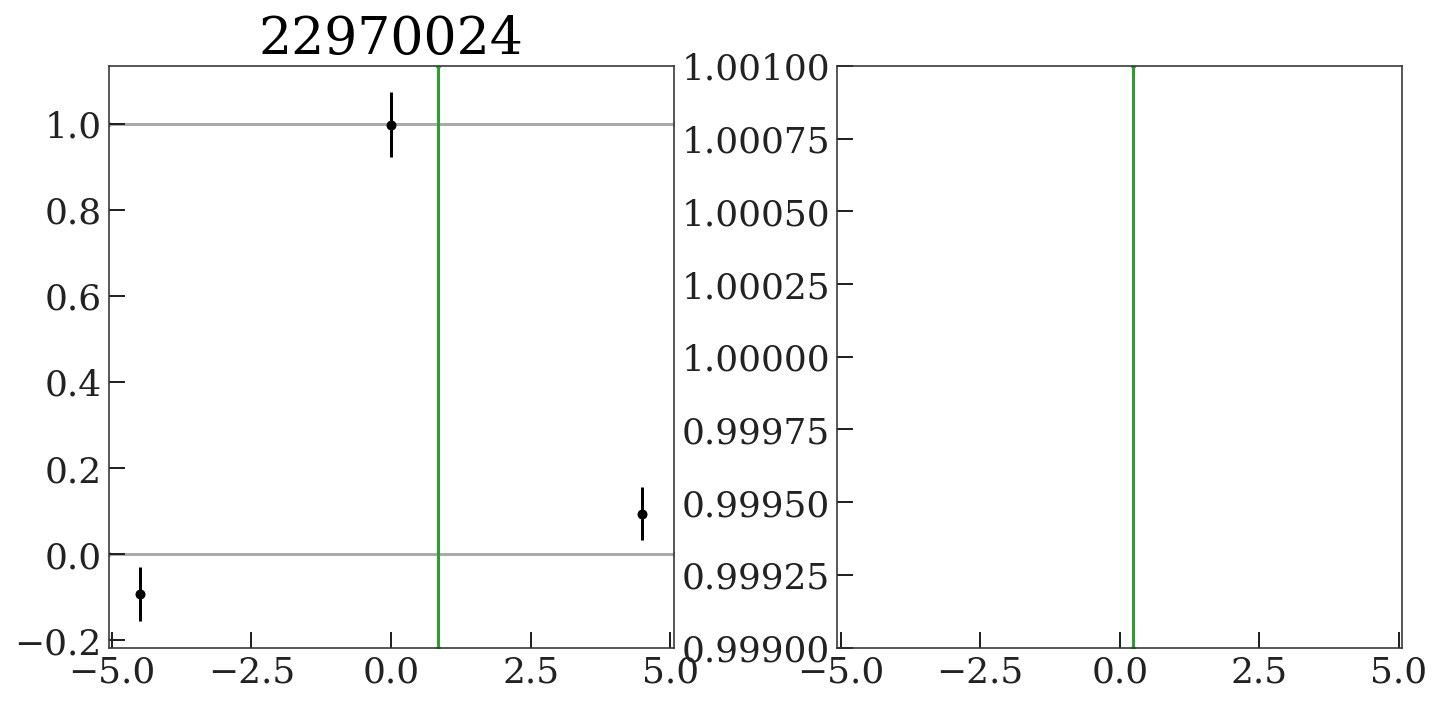

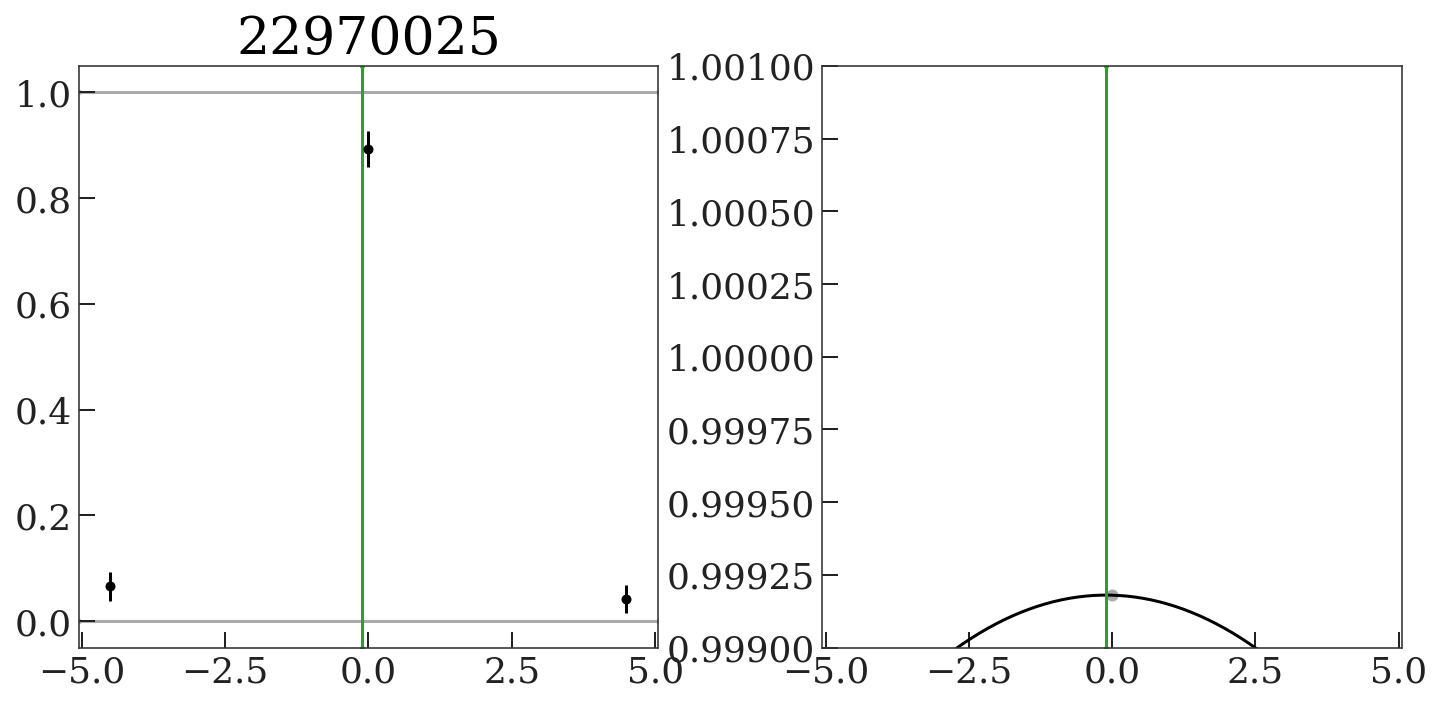

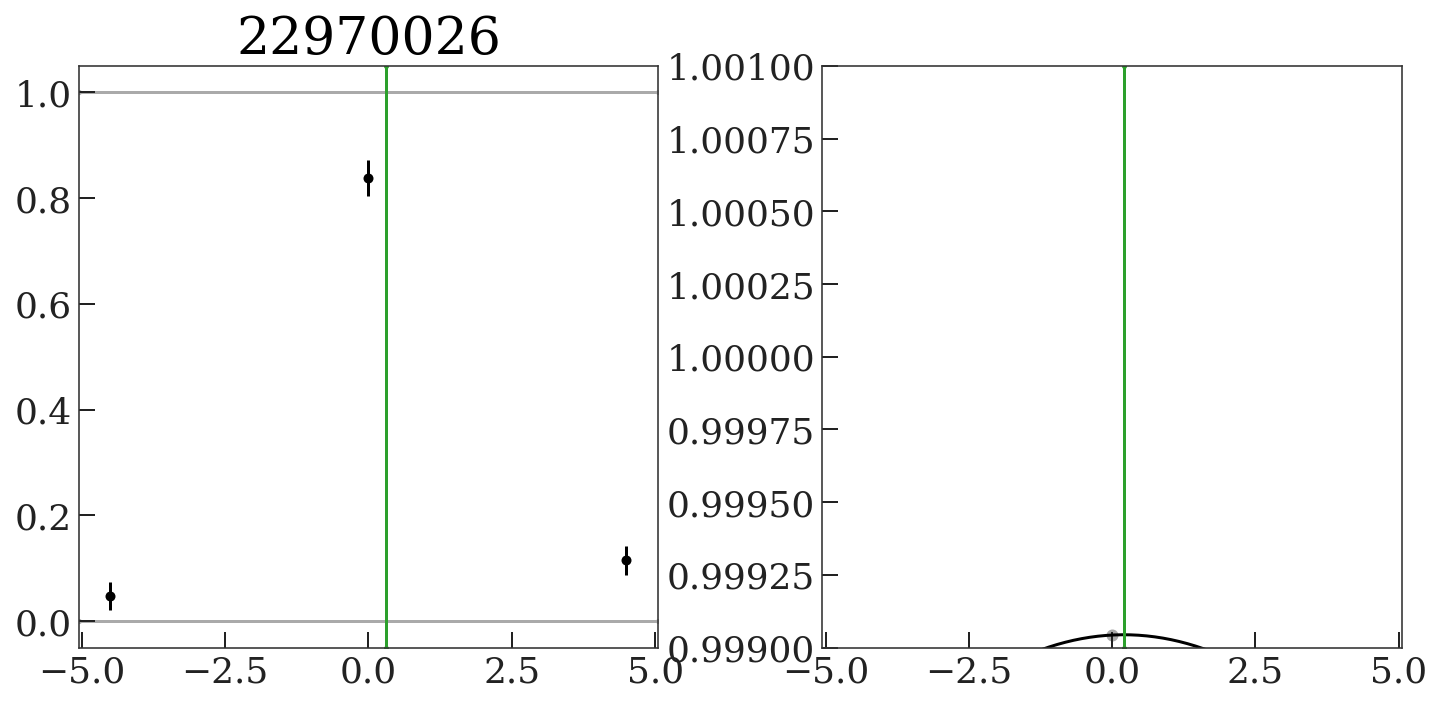

In [215]:
mjds = []
dvs = []
cc_dvs = []
for frame, s in sorted(spectra.items(), key=lambda x: int(x[0])):
    t = Time(hduls[frame][0].header['DATE-OBS'], scale='tai')
    mjds.append(t.tcb.mjd)
    
    normed_ref_spectrum, clip_mask = normalize_ref_to_frame(s, apvisit_spectrum, 
                                                            sigma_clip=False)
    kernel, kernel_cov, vs, cc = estimate_kernel(
        s, normed_ref_spectrum, 
        clip_mask=clip_mask, 
        K_half=1)
    
    cc_dv, cc_poly = parabola_hack(vs.value, cc)
    
    dvs.append(np.sum(kernel * vs.value) / np.sum(kernel))
    cc_dvs.append(cc_dv)
    
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(normed_ref_spectrum.wavelength.value,
#              normed_ref_spectrum.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.plot(s.wavelength.value,
#              s.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.xlim(16500, 16700)
#     # plt.ylim(0.5, 1.5)
    
#     if clip_mask is not None:
#         for val in s.wavelength.value[clip_mask]:
#             plt.axvline(val, color='tab:red', alpha=0.2, zorder=-100)
    
    # ---
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                             sharex=True)
    
    ax = axes[0]
    ax.errorbar(vs.value, kernel, np.sqrt(np.diag(kernel_cov)),
                marker='o', ls='none')
    
    ax.axhline(0, zorder=-10, color='#aaaaaa')
    ax.axhline(1, zorder=-10, color='#aaaaaa')
    ax.axvline(np.sum(kernel * vs.value) / np.sum(kernel), 
               color='tab:green')
    ax.set_title(frame)
    
    ax = axes[1]
    
    ax.scatter(vs.value, cc, color='#aaaaaa')
    grid = np.linspace(vs.value.min(), vs.value.max(), 128)
    ax.plot(grid, cc_poly(grid), marker='')
    ax.axvline(cc_dv, color='tab:green')
    ax.set_ylim(0.999, 1.001)
    
    fig.tight_layout()

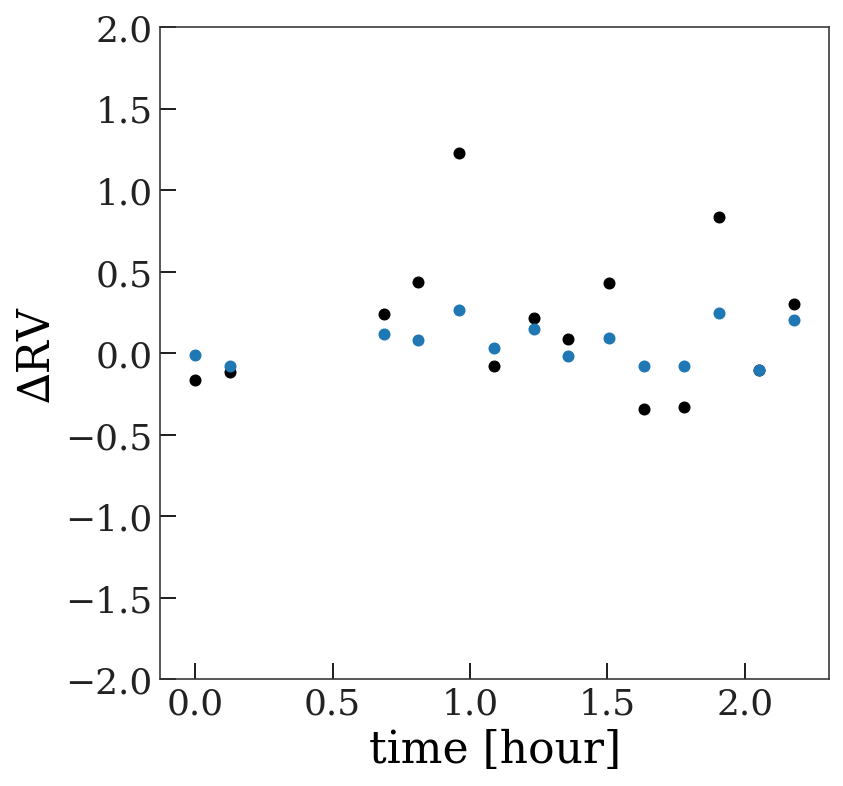

In [220]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
plt.ylim(-2, 2)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)